# Gravitational Wave Localizations and Galaxy Crossmatch Module

**Lecturer:** Leo Singer<br>
**Jupyter Notebook Authors:** Leo Singer, Dave Cook, Shreya Anand & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2019.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2019.html
## Objective
Learn how to use LIGO/Virgo localizations and cross-match with galaxies.
## Key steps
- Manipulate HEALPix localization files
- Cross-match a LIGO localization with a galaxy catalog

## Required dependencies

The following required dependencies should be obtainable via the Google Colab, but should also be installable to your local environment using `pip install <module>` and `conda install <module>`.

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib
* healpy
* ligo.skymap

### External packages
None

## Imports

First, some imports: Numpy, Matplotlib, Healpy, and parts of Astropy.

In [1]:
import astropy.utils.data
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp

Here are some extra imports for the galaxy cross matching:

In [2]:
from astropy.table import Table, vstack, hstack, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
import ligo.skymap.plot
from scipy.stats import norm
import scipy.stats

And configure Matplotlib to send plot output directly to the notebook:

In [3]:
%matplotlib inline

## HEALPix Basics

This section on using HEALPix localization files is adapted from the [LIGO/Virgo Public Alerts User Guide](https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html).

### Download and read localization

Let's start by downloading a sample localization file from the User Guide. We could do this on the command line using `curl`:

    $ curl -O https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz

But after all, this is a Python lesson, so let's download the file using the handy `astropy.utils.data.download_file` function from Astropy.

In [4]:
url = 'https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz'
filename = astropy.utils.data.download_file(url)

Next, let's read in the HEALPix data using Healpy. Note that by default, Healpy only reads the first column, which provides the 2D probability distribution on the sky.

In [5]:
prob = hp.read_map(filename)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


### Manipulating HEALPix Coordinates

To get a quick look at a HEALPix data set, you can use the `hp.mollview` function:

/opt/anaconda3/envs/knsim3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/anaconda3/envs/knsim3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/anaconda3/envs/knsim3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered co

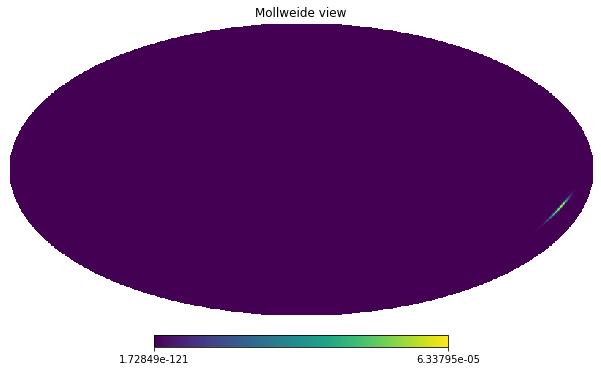

In [6]:
hp.mollview(prob)

What actually is stored in `prob`?

In [7]:
prob

array([2.70726059e-66, 1.27374324e-66, 2.62611513e-67, ...,
       2.04700874e-40, 1.05781210e-35, 4.44174764e-31])

It's a one-dimensional array! Yet it represents in 2D image. How does that work? HEALPix is a way to *index* equal-area regions on the unit sphere using integers.

To decode HEALPix indices, you need to know the resolution of the map, which is described by a parameter called `nside`. `nside` is the number of subdivisions of 12 base HEALPix tiles, so the relation between the length of a HEALPix array, `npix`, and its resolution, `nside`, is

$$
    \mathsf{npix} = 12 \cdot \mathsf{nside}^2.
$$

The functions `hp.npix2nside` and `hp.nside2npix` convert between length and resolution.

In [8]:
npix = len(prob)
npix

50331648

In [9]:
nside = hp.npix2nside(npix)
nside

2048

The function `hp.pix2ang` allow us to convert from (ra, dec) and HEALPix pixel index.

*Note*: by default, these functions return 'physics' spherical coordinates $(\theta, \phi)$ in radians, but you can switch to 'astronomy' spherical coordinates in degrees by passing the keyword argument `lonlat=True`.

Let's look up the right asce3nsion and declination of pixel 123.

In [10]:
ipix = 123
ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
ra, dec

(129.375, 89.81725848475484)

The function `hp.ang2pix` does the opposite. Let's find the pixel that contains the point RA=194.95, Dec=27.98.

In [11]:
ra = 194.95
dec = 27.98
hp.ang2pix(nside, ra, dec, lonlat=True)

13361492

What is the most probable sky location? Just find the pixel with the maximum value, and then find its right ascension and declination.

In [12]:
ipix_max = np.argmax(prob)
ipix_max

32883013

In [13]:
hp.pix2ang(nside, ipix_max, lonlat=True)

(194.30419921875, -17.856895095545454)

## Probability distributions with scipy.stats

Finding the most probable sky location within a HEALPix map involves knowing which pixels correspond to a certain probability contour (say, 90%).  We can gain insight into how these probability contours are calculated using scipy.stats.  Scipy provides a "t" distribution class that we can use to get values from the "t" statistic probability density function (PDF). As a start, we plot the PDF for a "t" statistic with 3 degrees of freedom:

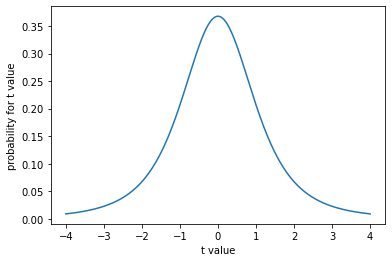

In [14]:
t_dist = scipy.stats.t(3)
t_values = np.linspace(-4, 4, 1000)
plt.plot(t_values, t_dist.pdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value')
plt.show()

The t distribution object t_dist can also give us the cumulative distribution function (CDF). The CDF gives the area under the curve of the PDF at and to the left of the given t value:

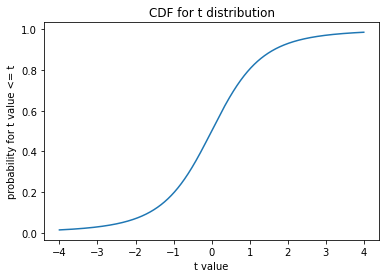

In [15]:
plt.plot(t_values, t_dist.cdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value <= t')
plt.title('CDF for t distribution')
plt.show()

Say I have a t value x drawn from a t distribution. The PDF gives the probability for given values of x. Because it is a probability density, the sum of the probabilities of all possible values for x: ∞<x<∞ must be 1. Therefore the total area under the PDF curve is 1, and the maximum value of the CDF is 1.

The CDF gives us the area under the PDF curve at and to the left of a given t value x. Therefore it is the probability that we will observe a value x<=t if we sample a value x from a t distribution.

Let's show relationship of PDF and CDF for three example t values.

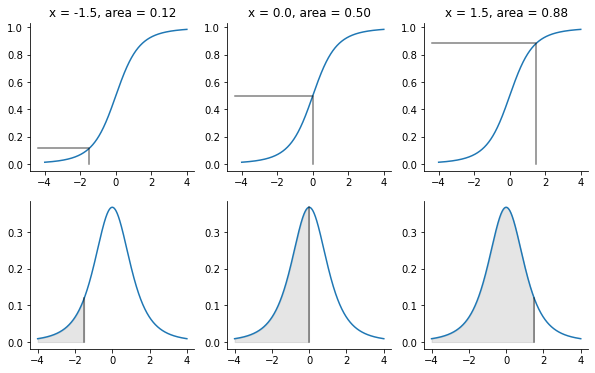

In [16]:
example_values = (-1.5, 0, 1.5)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)
fill_color = (0, 0, 0, 0.1)  # Light gray in RGBA format.
line_color = (0, 0, 0, 0.5)  # Medium gray in RGBA format.
fig, axes = plt.subplots(2, len(example_values), figsize=(10, 6))
for i, x in enumerate(example_values):
    cdf_ax, pdf_ax = axes[:, i]
    cdf_ax.plot(t_values, cdf_values)
    pdf_ax.plot(t_values, pdf_values)
    # Fill area at and to the left of x.
    pdf_ax.fill_between(t_values, pdf_values,
                        where=t_values <= x,
                        color=fill_color)
    pd = t_dist.pdf(x)  # Probability density at this value.
    # Line showing position of x on x-axis of PDF plot.
    pdf_ax.plot([x, x],
                [0, pd], color=line_color)
    cd = t_dist.cdf(x)  # Cumulative distribution value for this x.
    # Lines showing x and CDF value on CDF plot.
    x_ax_min = cdf_ax.axis()[0]  # x position of y axis on plot.
    cdf_ax.plot([x, x, x_ax_min],
                [0, cd, cd], color=line_color)
    cdf_ax.set_title('x = {:.1f}, area = {:.2f}'.format(x, cd))
    # Hide top and right axis lines and ticks to reduce clutter.
    for ax in (cdf_ax, pdf_ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

For example, say I have drawn a t value x at random from a t distribution. The probability that x<=1.5 is (i.e., >0.9253):

In [17]:
t_dist.cdf(1.5)

0.8847080673775886

The total area under the PDF is 1, and the maximum value for the CDF is 1. Therefore the area of the PDF to the right of 1.5 must be (i.e., >0.0746):

In [18]:
1 - t_dist.cdf(1.5)

0.11529193262241144

This is the probability that our t value x will be >1.5. In general, when we sample a value x at random from a t distribution, the probability that x>q is given by:

ℙ(x>q)=1−CDF(q), where CDF is the cumulative distribution function for a t value. We can apply the same methodology to HEALpix pixel probabilities in LIGO/VIRGO localization maps. 

## Working with LIGO/Virgo 3D localizations and Cross-Matching to Galaxy Catalogs

First, let's get our galaxy catalog that we will later match to the 3D localization of GW170817.

For this Section we will use a galaxy catalog from the CLU project (Census of the Local Universe; paper: https://ui.adsabs.harvard.edu/abs/2017arXiv171005016C/abstract). However, we will only use those galaxies that are publically availble and in NED (NASA/IPAC Extragalactic Database: https://ned.ipac.caltech.edu/). This catalog has already been prepared for you.

load CLU catalog into astropy table.

In [4]:
clu=Table.read('data/CLU.hdf5')
nclu=np.size(clu)

Add probability columns to the galaxy catalog: probability density and p-value per volume and per area.

In [5]:
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])

In [7]:
clu.colnames

['name',
 'ra',
 'dec',
 'distmpc',
 'a',
 'b2a',
 'pa',
 'btc',
 'magb',
 'sfr_fuv',
 'mstar',
 'dP_dV',
 'P',
 'dP_dA',
 'P_A']

Familiarize yourself with the catalog

print the columns in the catalog that will be used in the cross-match.

In [9]:
clu['name','ra','dec','distmpc','a','b2a','magb','sfr_fuv','mstar']

name,ra,dec,distmpc,a,b2a,magb,sfr_fuv,mstar
,deg,deg,Mpc,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64
6dFgs gJ0001313-055904,0.38083,-5.98433,0.0556771419942379,nan,nan,25.301416397094727,nan,336.60756522868667
2MASX J00021772-4345168,0.57383,-43.75467,175.22024536132812,nan,0.416869,16.299999237060547,nan,19468772606.159004
2MASX J00022478-5445592,0.60321,-54.76653,139.5183563232422,nan,0.60256,15.859999656677246,nan,14329555096.85143
MRSS 349-063591,0.74187,-35.79772,198.0797119140625,nan,nan,nan,0.44508742359504405,19799307276.171944
2MASX J00030209-3600152,0.75863,-36.00426,198.10708618164062,nan,nan,nan,nan,25419676830.957485
IRAS F00012-5451 ID,0.948375,-54.5740833333,147.08892822265625,nan,nan,nan,nan,494003437.822152
MRSS 349-058718,0.99855,-36.28124,199.5813751220703,nan,nan,nan,0.6278534101788935,6637583928.644948
2MASX J00040601-5134568,1.02517,-51.5825,147.1461181640625,nan,nan,nan,nan,20121836852.042862


'RA'=Right Ascension in degrees <br>
'Dec'=Declination in degrees  <br>
'MODELMAG_R'=SDSS r-band magnitude  <br>
'MODELMAGERR_R'=SDSS r-band magnitude Error  <br>
'K_M_K20FE'=2MASS K-band magnitude  <br>
'K_MSIG_K20FE'=2MASS K-band magnitude Error  <br>
'W1MPRO'=WISE W1 magnitude (3.6 micron)  <br>
'W1SIGMPRO'=WISE W1 magnitude Error  <br>

### Student Exercise
Use the astropy.coordinates package and the SkyCoord function to store all of the galaxy catalog's locations. 

The astropy coordinates package provides classes for representing a variety of celestial/spatial coordinates and their velocity components, as well as tools for converting between common coordinate systems in a uniform way. In addition, the astropy coordinates package facilitates fast manipulation and cross-matching. See here for examples: https://docs.astropy.org/en/stable/coordinates/

Create a coordinate object for the entire CLU catalog (hint: use SkyCoord).

In [12]:
clucoord=SkyCoord(ra=clu['ra'],dec=clu['dec'])

### GW170817 3D Localization

Now let's read in the LIGO/VIRGO HEALpix map for GW170817.

LIGO/Virgo localization files for compact binary mergers include directional estimates of distance. The distance information is stored in three additional columns. To get the distance estimates, we need to ask for all four columns: `PROB`, `DISTMU`, `DISTSIGMA`, and `DISTNORM`.

In [13]:
url = 'https://dcc.ligo.org/public/0146/G1701985/001/preliminary-LALInference.fits.gz'
filename = astropy.utils.data.download_file(url)

prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

npix = len(prob)
nside = hp.npix2nside(npix)
pixarea = hp.nside2pixarea(nside)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


`PROB` - cumulative distribution function

`DISTMU` - distance location parameter (Mpc)

`DISTSIGMA` - distance scale parameter (Mpc)

`DISTNORM` - distance normalization factor (Mpc$^{-2}$)

### Student Exercise

Find the coordinates of the highest probability pixel and put the coordinates into an astropy coordinate object called 'center'

In [14]:
ipix_max = np.argmax(prob)
ra_max, dec_max = hp.pix2ang(nside, ipix_max, lonlat=True)
center = SkyCoord(ra=ra_max*u.deg,dec=dec_max*u.deg)
print('Coordinates (RA,Dec) = %s' %(center))

Coordinates (RA,Dec) = <SkyCoord (ICRS): (ra, dec) in deg
    (197.35839844, -25.61308322)>


### Other plotting packages for LIGO/VIRGO HEALPix maps.

There are many visualization packages for plotting HEALPix maps. Luckily, LIGO has taken the time to provide its own user-friendly wrapper for plotting LIGO/VIRGO localizations.

Let's plot the sky localization using an 'astroglobe' projection centered on the highest highest probability pixel and overplot this location using the ligo.skymap package. (see here: https://lscsoft.docs.ligo.org/ligo.skymap/ligo/skymap/plot/allsky.html)

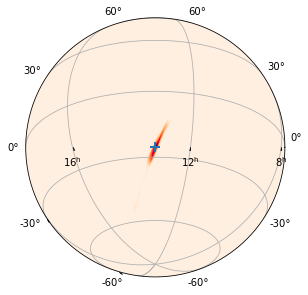

In [15]:
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax.grid()
ax.imshow_hpx(filename, cmap='cylon')
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=2)

### Student Exercises
1. Back to the galaxy catalog. Calculate the HEALPix index for each galaxy.

In [16]:
ipix = hp.ang2pix(nside, clu['ra'].value, clu['dec'].value, lonlat=True)

2. Compute the probabilities of each galaxy: per area, per radial distance, and per volume.

In [18]:
#probability density per area on the sky for each galaxy
dp_dA=prob[ipix]/pixarea
clu['dP_dA']=dp_dA

#probability along radial distance
dp_dr=clu['distmpc'].value**2 * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['distmpc'].value)

#probability density per volume
dp_dV=prob[ipix] * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['distmpc'].value)/pixarea 
clu['dP_dV']=dp_dV

3. Use a normalized cumulative dist function to calculate P-value per area for each galaxy (hint: use np.cumsum).

In [20]:
clu.sort('dP_dA')
clu.reverse()
cum_sort=np.cumsum(clu['dP_dA'])
cumnorm_sort=cum_sort/np.max(cum_sort)
clu['P_A']=cumnorm_sort

#ID galaxies inside the 90% prob by volume
icutarea90=np.where(clu['P_A'] <= 0.9)
clucutarea90=clu[icutarea90]

#generate astropy coordinate object for this sample
clucutarea90coord=SkyCoord(ra=clucutarea90['ra'],dec=clucutarea90['dec'])

print('# of galaxies in 90%% Area = %i' %(np.size(icutarea90)))

#sort the galaxies by P-value and print out top 20
clucutarea90['name','dP_dA','P_A'][0:20].pprint(max_lines=22)

# of galaxies in 90% Area = 944
            name                   dP_dA                 P_A         
---------------------------- ------------------ ---------------------
     2MASX J13085466-2526013  328.4708057481784 0.0071467533219292945
     2MASX J13085215-2530351 325.23540442145713   0.01422311190930417
     2MASX J13105449-2605323 313.15080651412734  0.021036538026800423
              ESO 508- G 016 312.78382586238115   0.02784197950716591
     2MASX J13113020-2619386 300.98559528753657   0.03439071919827618
     2MASX J13121111-2639115 285.19998707962714   0.04059600112716134
GALEXASC J131215.12-264630.4   282.127096965202   0.04673442418381531
              ESO 508- G 025  276.5933656229848  0.052752446242387965
     2MASX J13120748-2630035  272.9284251884063  0.058690727804188506
              ESO 508- G 003 260.04855554117916    0.0643487736507398
     2MASX J13123929-2642121  257.9949138461368   0.06996213707696862
     2MASX J13121969-2633515    257.30556126262   0.075560

### Plot the top 20 highest probability galaxies and add a zoomed-in inset.

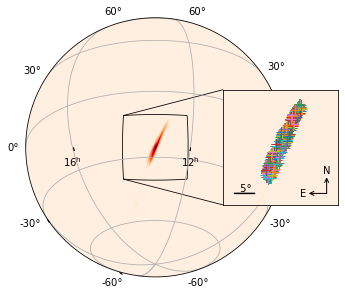

In [21]:
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

#Zoomed-in inset window to better view the locations of the galaxies.
ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=15*u.deg)
for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')
ax_inset.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')

for coord in clucutarea90coord:
    ax_inset.plot(
    coord.ra.deg, coord.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=1)

plt.show()

## Exercise for students - Put it all Together...

Following the examples above, find galaxies in 90% __VOLUME__ probability contour for GW170817, sort by Wise W1 luminosity, and overplot the top 20 sorted galaxies.

Information on WISE zeropoints and flux transformations
http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

### Part I - Find the galaxies in the 90% volumne probability

In [23]:
#load in CLU catalog
clu=Table.read('data/CLU.hdf5')
clucoord=SkyCoord(ra=clu['ra'],dec=clu['dec'])
nclu=np.size(clu)

#make astropy coordinate object of CLU galaxies
clucoord=SkyCoord(ra=clu['ra'],dec=clu['dec'])

#sky localization colmns to the galaxy catalog: probability density and p-value per volume and per area.
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])

#load in healpix map
prob,distmu,distsigma,distnorm=hp.read_map('data/GW170817_prelim.fits.gz',field=[0,1,2,3],dtype=('f8','f8','f8','f8'))
npix=len(prob)
nside=hp.npix2nside(npix)
pixarea=hp.nside2pixarea(nside)

#get coord of max prob density for plotting purposes
ipix_max = np.argmax(prob)
theta_max, phi_max = hp.pix2ang(nside, ipix_max)
ra_max = np.rad2deg(phi_max)
dec_max = np.rad2deg(0.5 * np.pi - theta_max)
center = SkyCoord(ra=ra_max*u.deg,dec=dec_max*u.deg)
print(center)

#calc hp index for each galaxy and populate CLU Table with the values
theta=0.5 * np.pi - clucoord.dec.to('rad').value
phi=clucoord.ra.to('rad').value
ipix=hp.ang2pix(nside,theta,phi)
#calc probability density per volume for each galaxy
dp_dV=prob[ipix] * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['distmpc'])/pixarea 
clu['dP_dV']=dp_dV

#use normalized cumulative dist function to calculate Volume P-value for each galaxy
clu.sort('dP_dV')
clu.reverse()
cum_sort=np.cumsum(clu['dP_dV'])
cumnorm_sort=cum_sort/np.max(cum_sort)
clu['P']=cumnorm_sort

#ID galaxies inside the 90% prob by volume
icut90=np.where(clu['P'] <= 0.9)
clucut90=clu[icut90]

#generate an astropy coordinate object for this subset
clucut90coord=SkyCoord(ra=clucut90['ra'],dec=clucut90['dec'])

print('# of galaxies in 90%% volume = %i' %(np.size(clucut90)))



NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
<SkyCoord (ICRS): (ra, dec) in deg
    (197.35839844, -25.61308322)>
# of galaxies in 90% volume = 38


Q: Why are there so fewer galaxies in the volumne probability?
A: Taking into account distance puts tighter constraints on the sample.

Part II - Sort by Stellar Mass

In [24]:
#sort by galaxy stellar mass
clucut90.sort('mstar')
clucut90.reverse()

#then print list of prioritized galaxies
clucut90['name','mstar','dP_dV','P'][0:20].pprint(max_lines=22)


#Q: Is NGC4993 in your list?
#A: It should be #5

            name                   mstar        ...          P         
---------------------------- ------------------ ... -------------------
GALEXMSC J132152.52-312233.6                nan ...  0.8659323537237527
                    NGC 4970  22111885147.36046 ...  0.4054957389550534
                    NGC 4830  19691036859.45966 ...  0.8179830893324261
                     IC 4197 19393166571.432167 ...  0.7578613837256465
                    NGC 4993  17683346320.92309 ...  0.7829165242624563
                    NGC 4968 16779785547.729984 ...   0.294926035603021
                    NGC 5048  15272176898.57502 ...  0.6902558637380628
                     IC 4180  14101524009.45723 ...  0.2141998536668124
              ESO 508- G 033   9224537312.57565 ...  0.8064365544422254
                     IC 0874  7289035203.022445 ...  0.8856973740297853
              ESO 508- G 010  3315838711.838766 ...  0.7303499457682924
     2MASX J13161781-2926415 2547607640.1172214 ...  0.895506118

### Part III - Plot up the sky localization and overplot the top 20 sorted galaxies on it.

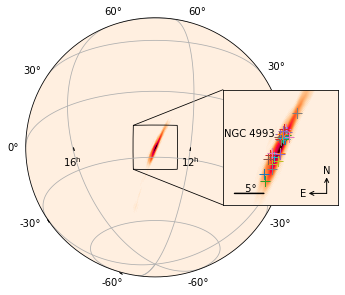

In [25]:
#plot up the sky localization and overplot the galaxies
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')
ax_inset.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')
for coord in clucut90coord:
    ax_inset.plot(
    coord.ra.deg, coord.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=1)

#where is NGC4993? hint: use ax_inset.text()
c4993=SkyCoord.from_name('NGC 4993')
ax_inset.text(c4993.ra.deg+10.5, c4993.dec.deg,'NGC 4993',transform=ax_inset.get_transform('world'),fontdict={'size':10,'color':'black','weight':'normal'})

plt.show()